In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
import xgboost as xgb
%config InlineBackend.figure_format = 'png'

In [2]:
train = pd.read_csv("input/listings.csv")

In [3]:
columns_to_keep = ["price", "neighbourhood_cleansed", "bedrooms",
                   "property_type", "room_type", "name", "summary",
                   "amenities", "latitude", "longitude", "number_of_reviews",
                   "require_guest_phone_verification", "minimum_nights"]

train = train[columns_to_keep]
inp = [['0', 'Roslindale', 1.0, 'House', 'Entire home/apt', 'Sunny Bungalow in the City', 'Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  attractive stores, groceries & local restaurants. Friendly neighborhood. Access public transportation.','{TV,"Wireless Internet",Kitchen,"Free Parking on Premises","Pets live on this property",Dog(s),Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Fire Extinguisher",Essentials,Shampoo,"Laptop Friendly Workspace"}', 42.28261879577949, -71.13306792912681, 0, 'f', 2]]

In [4]:
inp = pd.DataFrame(inp, columns = columns_to_keep)

In [5]:
train.append(inp, ignore_index=True)

,price,neighbourhood_cleansed,bedrooms,property_type,room_type,name,summary,amenities,latitude,longitude,number_of_reviews,require_guest_phone_verification,minimum_nights
0,$250.00,Roslindale,2.0,House,Entire home/apt,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...","{TV,""Wireless Internet"",Kitchen,""Free Parking ...",42.282619,-71.133068,0,f,2
1,$65.00,Roslindale,1.0,Apartment,Private room,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,"{TV,Internet,""Wireless Internet"",""Air Conditio...",42.286241,-71.134374,36,f,2
2,$65.00,Roslindale,1.0,Apartment,Private room,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",42.292438,-71.135765,41,f,3
3,$75.00,Roslindale,1.0,House,Private room,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,"{TV,Internet,""Wireless Internet"",""Air Conditio...",42.281106,-71.121021,1,f,1
4,$79.00,Roslindale,1.0,House,Private room,Come Home to Boston,"My comfy, clean and relaxing home is one block...","{Internet,""Wireless Internet"",""Air Conditionin...",42.284512,-71.136258,29,f,2
5,$75.00,Roslindale,1.0,Condominium,Private room,Private Bedroom + Great Coffee,Super comfy bedroom plus your own bathroom in ...,"{""Cable TV"",""Wireless Internet"",""Air Condition...",42.291690,-71.131893,8,f,2
6,$100.00,Roslindale,1.0,Apartment,Entire home/apt,New Lrg Studio apt 15 min to Boston,It's a 5 minute walk to Rosi Square to catch t...,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",42.281390,-71.131190,57,f,1
7,$75.00,Roslindale,1.0,House,Private room,"""Tranquility"" on ""Top of the Hill""","We can accommodate guests who are gluten-free,...","{TV,Internet,""Wireless Internet"",""Air Conditio...",42.281946,-71.141022,67,t,1
8,$58.00,Roslindale,1.0,Condominium,Private room,6 miles away from downtown Boston!,Nice and cozy apartment about 6 miles away to ...,"{""Wireless Internet"",""Pets live on this proper...",42.285878,-71.124910,65,f,2
9,$229.00,Roslindale,2.0,Apartment,Entire home/apt,Perfect & Practical Boston Rental,This is a cozy and spacious two bedroom unit w...,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",42.288820,-71.139510,33,f,4


In [6]:
train.dtypes

price                                object
neighbourhood_cleansed               object
bedrooms                            float64
property_type                        object
room_type                            object
name                                 object
summary                              object
amenities                            object
latitude                            float64
longitude                           float64
number_of_reviews                     int64
require_guest_phone_verification     object
minimum_nights                        int64
dtype: object

In [7]:
#train.head(3)

In [8]:
def clean(train):

    train["bedrooms"] = train["bedrooms"].fillna(0.5) #these are studios
    train["summary"] = train["summary"].fillna("")
    #train["bedrooms"] = train["bedrooms"].astype("str")

    #replace unpopular types with other 
    popular_types = train["property_type"].value_counts().head(6).index.values
    train.loc[~train.property_type.isin(popular_types), "property_type"] = "Other"

    #make price numeric:
    train["price"] = train["price"].str.replace("[$,]", "").astype("float")
    #eliminate crazy prices:
    train = train[train["price"] < 600]
    
    return train

In [9]:
train = clean(train)

98.37957922657978

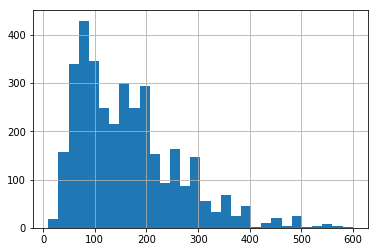

In [10]:
train["price"].hist(bins = 30)
train["price"].std()

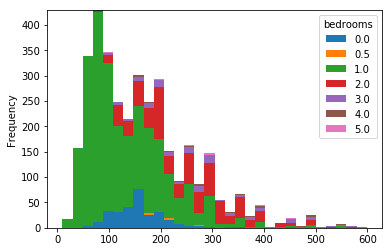

In [11]:
(train.pivot(columns = "bedrooms", values = "price")
         .plot.hist(bins = 30, stacked = True))

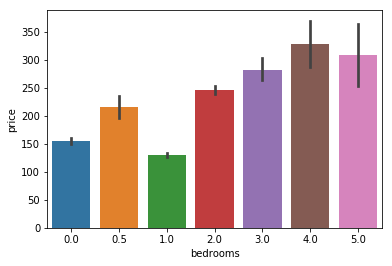

In [12]:
sns.barplot(x = "bedrooms", y = "price", data = train)

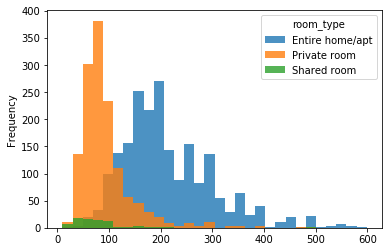

In [13]:
(train.pivot(columns = "room_type", values = "price")
         .plot.hist(bins = 30, stacked = False, alpha = 0.8))

In [14]:
train.groupby("room_type")["price"].mean()

room_type
Entire home/apt    213.848369
Private room        92.080845
Shared room         84.443038
Name: price, dtype: float64

In [15]:
y = train["price"]
train_num_cat = train[["neighbourhood_cleansed", "bedrooms",
                   "property_type", "room_type", "latitude", "longitude",
                   "number_of_reviews", "require_guest_phone_verification",
                    "minimum_nights"]]

train_text = train[["name", "summary", "amenities"]]

In [16]:
X_num = pd.get_dummies(train_num_cat)

In [17]:
train_text.head()

,name,summary,amenities
0,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...","{TV,""Wireless Internet"",Kitchen,""Free Parking ..."
1,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,"{TV,Internet,""Wireless Internet"",""Air Conditio..."
2,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","{TV,""Cable TV"",""Wireless Internet"",""Air Condit..."
3,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,"{TV,Internet,""Wireless Internet"",""Air Conditio..."
4,Come Home to Boston,"My comfy, clean and relaxing home is one block...","{Internet,""Wireless Internet"",""Air Conditionin..."


In [18]:
train.amenities = train.amenities.str.replace("[{}]", "")

In [19]:
amenity_ohe = train.amenities.str.get_dummies(sep = ",")

In [20]:
train.amenities = train.amenities.str.replace("[{}]", "")
amenity_ohe = train.amenities.str.get_dummies(sep = ",")

In [21]:
amenity_ohe.head(3)

,"""24-Hour Check-in""","""Air Conditioning""","""Buzzer/Wireless Intercom""","""Cable TV""","""Carbon Monoxide Detector""","""Elevator in Building""","""Family/Kid Friendly""","""Fire Extinguisher""","""First Aid Kit""","""Free Parking on Premises""",...,Gym,Hangers,Heating,Internet,Iron,Kitchen,Pool,Shampoo,TV,Washer
0,0,0,0,0,0,0,1,1,0,1,...,0,0,1,0,0,1,0,1,1,1
1,0,1,0,0,1,0,1,1,0,0,...,0,1,1,1,1,1,0,1,1,1
2,0,1,0,1,1,0,0,0,1,1,...,0,0,1,0,0,1,0,1,1,1


In [22]:
train["text"] = train["name"].str.cat(train["summary"], sep = " ")

In [23]:
vect = CountVectorizer(stop_words = "english", min_df = 10)
X_text = vect.fit_transform(train["text"])

In [34]:
#metric:
def rmse(y_true, y_pred):
    return(np.sqrt(metrics.mean_squared_error(y_true, y_pred)))

#evaluates rmse on a validation set:
def eval_model(model, X, y, state = 3):
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, random_state = state)
    preds = model.fit(X_tr, y_tr).predict(X_val)
    return rmse(y_val, preds)

def pred_val(model, X, y):
    X_train = X[:-1]
    Y_train = y[:-1]
    
    model.fit(X_train, Y_train)
    print(X[-2:-1])
    return model.predict([X[-1]])[0]
    

In [35]:
(X_num.shape, X_text.shape, amenity_ohe.shape)

((3536, 42), (3536, 1100), (3536, 45))

In [36]:
#this is numeric + amenities:
X = np.hstack((X_num, amenity_ohe))

#this is all of them:
X_full = np.hstack((X_num, amenity_ohe, X_text.toarray()))

In [37]:
pred_val(xgb.XGBRegressor(), X, y)

[[  1.          42.38522635 -71.08092263   2.           1.
    0.           0.           0.           0.           0.
    1.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    1.           0.           0.           0.           0.
    0.           0.           0.           1.           0.
    1.           0.           0.           0.           0.
    0.           0.           0.           1.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    1.           0.           0.           0.           0.
    1.           1.           1.           1.           0.
    0.           0.           1.           0.           

80.54602

In [34]:
models_rmse = [eval_model(xgb.XGBRegressor(), X_num, y),
 eval_model(xgb.XGBRegressor(), X, y),
 eval_model(Ridge(), X_num, y),
 eval_model(Ridge(), X, y),
 eval_model(xgb.XGBRegressor(), X_full, y)]

In [35]:
models_rmse = pd.Series(models_rmse, index = ["xgb_num", "xgb_ame", "ridge", "ridge_ame", "xgb_full"] )

In [28]:
models_rmse

xgb_num      58.786255
xgb_ame      57.516002
ridge        60.078641
ridge_ame    58.446793
dtype: float64

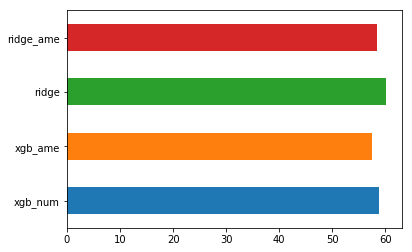

In [29]:
models_rmse.plot(kind = "barh")

In [30]:
results = []
for i in range(30):
    X_tr, X_val, y_tr, y_val = train_test_split(X_num, y)
    y_baseline = [np.mean(y_tr)]*len(y_val)

    model = Ridge(alpha = 5)
    preds_logit = model.fit(X_tr, y_tr).predict(X_val)


    model = xgb.XGBRegressor()  
    preds_xgb = model.fit(X_tr, y_tr).predict(X_val)
    
    results.append((rmse(y_baseline, y_val),
                    rmse(preds_logit, y_val),
                    rmse(preds_xgb, y_val)
                    ))

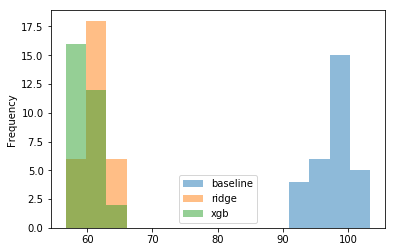

In [31]:
results = pd.DataFrame(results, columns = ["baseline", "ridge", "xgb"])
results.plot.hist(bins = 15, alpha = 0.5)

In [32]:
pd.DataFrame([results.mean(), results.std()])

,baseline,ridge,xgb
0,98.115695,61.401526,60.056387
1,3.029402,1.878966,2.059818
